# D213 - Advanced Data Analytics - Performance Assessment Task 1
## Joshua T. Funderburk

#### Programming Environment

In [1]:
from platform import python_version
print(f"Python version: {python_version()}")

Python version: 3.12.8


In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

In [3]:
# Read CSV & Load Data in to Pandas DataFrame
df = pd.read_csv(r'C:\Users\funde\Desktop\WGU\D213\Task 1\medical_time_series.csv', index_col=0)

# Print top 5 rows of the DataFrame
df.head()

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888


In [4]:
# Print the shape of the DataFrame
df.shape

(731, 1)

In [5]:
# Print the info of the DataFrame
df.info

<bound method DataFrame.info of        Revenue
Day           
1     0.000000
2    -0.292356
3    -0.327772
4    -0.339987
5    -0.124888
..         ...
727  15.722056
728  15.865822
729  15.708988
730  15.822867
731  16.069429

[731 rows x 1 columns]>

In [6]:
df.describe()

,Revenue
count,731.000000
mean,14.179608
std,6.959905
min,-4.423299
25%,11.121742
50%,15.951830
75%,19.293506
max,24.792249


In [7]:
# Convert day to a date
df['Date'] = (pd.date_range(start=datetime(2023, 1, 1), periods=df.shape[0], freq='24H'))

# Set the date as an index
df.set_index('Date', inplace=True)
df

,Revenue
Date,
2023-01-01,0.000000
2023-01-02,-0.292356
2023-01-03,-0.327772
2023-01-04,-0.339987
2023-01-05,-0.124888
...,...
2024-12-27,15.722056
2024-12-28,15.865822
2024-12-29,15.708988


#### Data Cleaning

In [8]:
# Look for null or missing values
df.isnull().any()

Revenue    False
dtype: bool

In [9]:
# Look for null or missing values
df.isnull().values.any()

False

# Part I: Research Question

## A1: Research Question

The research question for this analysis is: "Is it possible to accurately predict 180 days of the hospital system's revenue forecast using an ARIMA forecasting model?"

## A2: Objectives or Goals

The goal of this analysis is to determine if revenue can be predicted using ARIMA. This goal supports the hospital system's need to develop an accurate and reliable revenue forecasting system to improve financial planning and decision-making processes. The objectives of this analysis are:
1. To evaluate the stationarity and statistical properties of the historical hospital revenue data through time series decomposition and statistical tests.
2. To develop an ARIMA model by analyzing ACF/PACF plots and using auto_arima for model selection.
3. To validate the model's performance using error metrics.
4. To train and validate the model by splitting the data into test and training data sets. The model will be trained on the training set, which is the complete data set minus the final 180 days, and then the model will be compared to the test data set that contains the remaining 180 days to compare actual revenue values versus forecasted revenue values.

# Part II: Method Justification

## B: Summary of Assumptions

ARIMA time series models make the following assumptions:

1. Data exhibits autocorrelation
    - Autocorrelation means that current values are influenced by past values in the time series. This relationship is fundamental for ARIMA to make predictions (Sangarshanan, 2018).
    - ARIMA assumes that the influence can be captured through the autoregressive (AR) and moving average (MA) components.
    - Once the model is fitted, there should be no remaining autocorrelation in the residuals.
2. Data is stationary
    - Stationary data means that the properties of the time series do not depend on the time at which the data is observed (Chatterjee, 2018). In essence, stationary data has no long-term trend or seasonal effects.
    - While ARIMA models require stationary data, non-stationary data can be transformed into stationary data using techniques such as differencing, log transformations, or detrending. Once the data is made stationary, the ARIMA model parameters are estimated. The model can then be interpreted and used to forecast values for the non-stationary data.
3. Data is univariate
    - ARIMA models are designed to work with a single variable, meaning only one time series is used (Chatterjee, 2018). Other models, such as VARIMA, can accommodate multiple variables.
    - The Auto-Regression (AR) component of ARIMA explains how the current value of the time series depends on its past values. This univariate focus is key to ARIMA's simplicity and effectiveness.
4. There is a linear relationship between the current value of the time series and its past values and errors (Medium, 2023).
    - ARIMA uses a "straight-line" relationship to predict future values based on past data.


# Part III: Data Preparation

## C1: Line Graph Visualization

The following visualization represents the time series data in a line graph. Note that a single data transformation step was performed earlier in this analysis where a number that represents a day in a two year time period was converted to be an actual date. This is simply for visualization purposes and because Dr. Festus Elleh notes that there are some data scientists that believe ARIMA performs better with actual dates.

From analyzing the visualization, there is an apparent upward trend from the date of initial operation to the end of year 2. There was a steep increase in revenue from January 2023 to October 2023. After October 2023, revenue seems to have leveled off. There does not seem to be enough data in this visualization to make any assumptions on seasonality on the visualization alone. Ideally, a data set covering a larger range would be available so seasonality could be analyzed in a line graph by aggregating revenue by month.

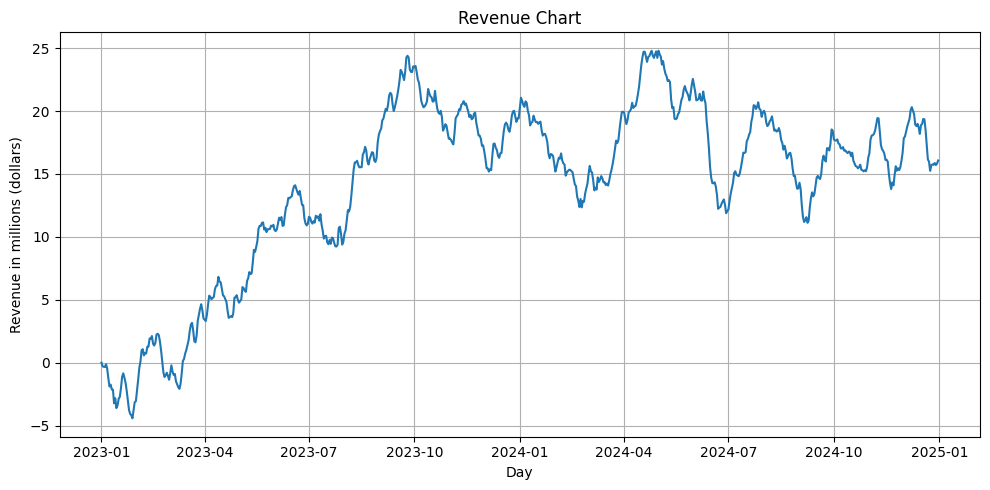

In [10]:
# Visualize the data
plt.figure(figsize=(10,5))
plt.plot(df['Revenue'])
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in millions (dollars)')
plt.grid(True)
plt.tight_layout()
plt.show()

## C2: Time Step Formatting

The hospital system's data set is a time series data set that is comprised of two columns. The two columns are 'day,' which is the day number beginning with the first day of operations, and revenue, which is represented in millions of dollars. There are 731 days included in the data set, indicating that one of the years represented was a leap year. As described previously, the day in this analysis has been transformed into an actual date to help with interpretation. There appear to be no gaps in measurement as each day has a revenue value.

## C3: Stationarity

Through two different analysis methods, the time series data is determined to be non-stationary. In order for data to be stationary it must not have a trend. The first method is through referring back to the revenue line graph in section C1, there is an obvious steep climb in revenue from the first day of hospital operations to October 2023 and while the following months level out, there still is certainly an upward trend for the data overall. The second method of stationarity determination is via running an Augmented Dickey-Fuller (adfuller) test. For stationary data, it is expected that the p-value of the result of the Augmented Dickey-Fuller test be less than 0.05. However, the test on this data set returns a p-value of 0.1997, which is far from being statistically significant. With those two methods in mind, it is apparent the data is non-stationary in its current form.

In [11]:
# Check for stationarity using the Augmented Dickey-Fuller test
adfuller_result = adfuller(df['Revenue'])
print("1. ADF: ", adfuller_result[0])
print("2. P-value: ", adfuller_result[1])
print("3. Num of lags: ", adfuller_result[2])
print("4. Num of obs used for ADF regression and critical values calc: ", adfuller_result[1])
print("5. Critical values: ", adfuller_result[4])

print("")

# Evaluate for stationarity
if adfuller_result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

1. ADF:  -2.218319047608944
2. P-value:  0.1996640061506439
3. Num of lags:  1
4. Num of obs used for ADF regression and critical values calc:  0.1996640061506439
5. Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}

The time series is non-stationary.


## C4: Steps to Prepare the Data 

The following are the steps performed to prepare the data for time series analysis:

1. Exploratory data analysis (completed in previous sections of this analysis)
    - Inspect the data to understand data structure and explore basic statistics
    - Check data types of the columns
    - Verify there are no missing values
    - Confirm continuous daily measurements with no gaps
2. Date index creation and formatting (completed in previous sections of this analysis)
    - Convert the 'Day' column to actual dates starting from January 1, 2023
    - Set the date as the index
3. Stationarity transformation
    - Test initial stationarity using Augmented Dickey-Fuller Test (completed in section C3)
    - Apply first-order differencing to achieve stationarity 
    - Remove any null values from dataset created by differencing
    - Confirm stationarity of transformed data through a second Augmented Dickey-Fuller Test
4. Train-test split
    - Split the data into training and test sets using the last 180 days as the test set
    - Set proper datetime indexes for both training and test set with daily frequency

#### Stationarity Transformation

Apply first-order differencing using df.diff() to achieve stationarity and remove null values created by differencing using dropna(). Confirm stationarity of transformed data througha  second Augmented Dickey-Fuller test, which shows p-value < 0.05.

In [12]:
# Make the data stationary
df_stationary = df.diff().dropna()

# View the data
df_stationary.head()

,Revenue
Date,
2023-01-02,-0.292356
2023-01-03,-0.035416
2023-01-04,-0.012215
2023-01-05,0.215100
2023-01-06,-0.366702


In [13]:
# Check for stationarity using the Augmented Dickey-Fuller test
adfuller_result = adfuller(df_stationary['Revenue'])
print("1. ADF: ", adfuller_result[0])
print("2. P-value: ", adfuller_result[1])
print("3. Num of lags: ", adfuller_result[2])
print("4. Num of obs used for ADF regression and critical values calc: ", adfuller_result[1])
print("5. Critical values: ", adfuller_result[4])

print("")

# Evaluate for stationarity
if adfuller_result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

1. ADF:  -17.374772303557062
2. P-value:  5.113206978840171e-30
3. Num of lags:  0
4. Num of obs used for ADF regression and critical values calc:  5.113206978840171e-30
5. Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}

The time series is stationary.


#### Train-test split

Split the data into training and test sets using the last 180 days as the test set. Set proper datetime indexes for both training and test sets with daily frequency using pd.DatetimeIndex

Data set information:
- Training set contains 551 observations (days 1-551)
- Test set contains 180 observations (days 552-731)

In [14]:
# Split non-stationary data into train and test
train_size = int(len(df) - 180)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Set Index values for train and test
train.index = pd.DatetimeIndex(train.index, freq='D')
test.index = pd.DatetimeIndex(test.index, freq='D')

## C5: Prepared Data Set

In [15]:
# Write the cleaned data to a csv file
df.to_csv('cleaned_data_d213_t1.csv', index=True)

# Write the training and test data sets to a csv file
train.to_csv('training_data_d213_t1.csv', index=True)
test.to_csv('test_data_d213_t1.csv', index=True)

# Part IV: Model Identification and Analysis

## D1: Report Findings and Visualizations

#### Decomposed Time Series

The following visualizations show the time series decomposed in to trend, season, and residual plots. For further analysis, these visualizations will be plotted seperately and accompanied by annotations.

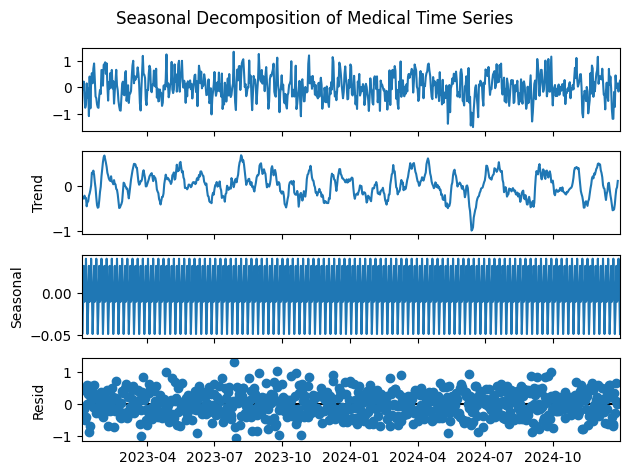

In [16]:
# Decompose the data
result = seasonal_decompose(df_stationary)

# Plot
result.plot()
plt.suptitle('Seasonal Decomposition of Medical Time Series')
plt.tight_layout()
plt.show()

#### Trend Component

The trend component visualization confirms that the data is in fact stationary. The plot no longers shows a consistent upward trend as identified in the line graph in section C1.

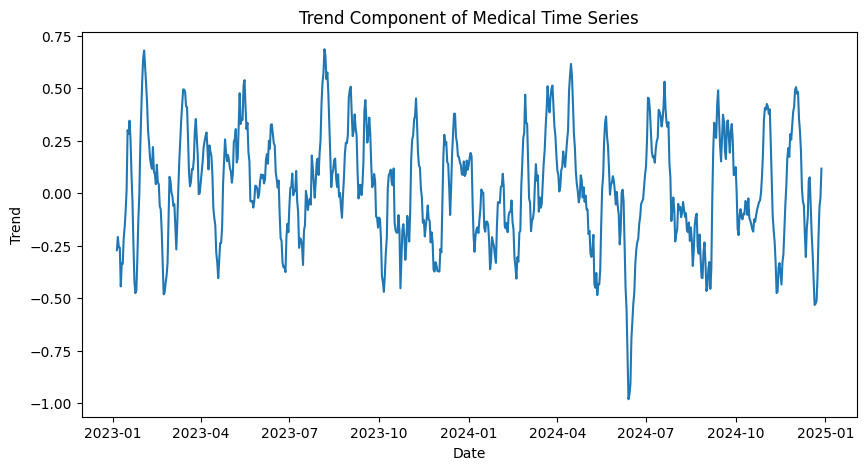

In [17]:
# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(result.trend, label='Trend Component')
plt.title('Trend Component of Medical Time Series')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.show()

#### Seasonal Component

The seasonal component shows a pattern that is repetitive and consistent over the entire time series. It does seem to reveal some minimal seasonal variation in hospital revenue, but the flucations are small. The small, near zero fluctuations (0.04 in either direction) suggests that revenue does not consistently follow predictable cycles. 

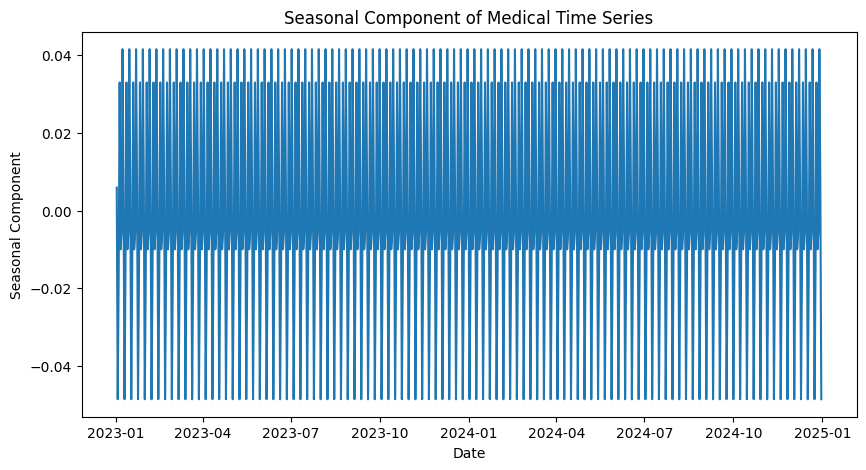

In [18]:
# Plot the seasonal component
plt.figure(figsize=(10, 5))
plt.plot(result.seasonal, label='Seasonal Component')
plt.title('Seasonal Component of Medical Time Series')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.show()

#### Confirmation of the lack of trends in the residuals of the decomposed series

The residual plot confirms that trends have been addressed in the data set. This can be concluded since the residuals are centered around zero and that there is no easily discernable pattern in the residuals. The lack of trends and patterns indicates the data set successfully captures the time series underlying structure.

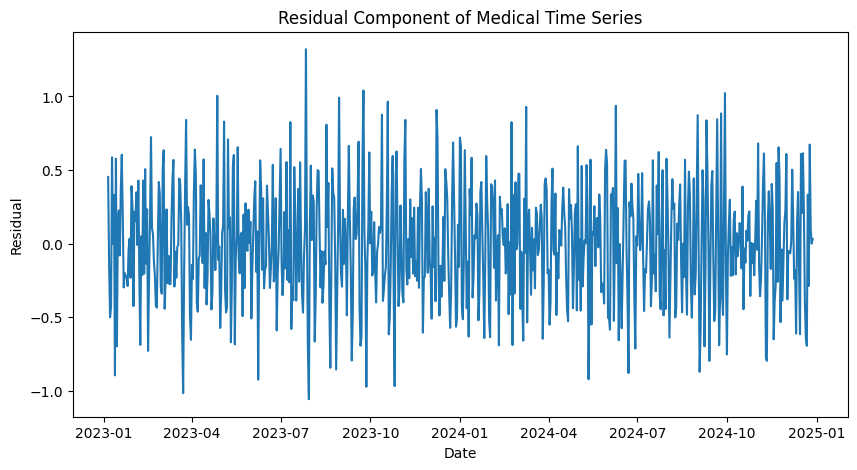

In [19]:
# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(result.resid, label='Residual Component')
plt.title('Residual Component of Medical Time Series')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

#### Autocorrelation

Calculating Autocorrelation off of 27 lags as the square root of 731 (days in the data set) is about 27.

Autocorrelation Function (ACF) - The ACF plot shows a sharp drag after lag 0 with spikes at early lags (particularly lag 1), but the correlations quickly decay to 0.  Given this clear cut off after lag one, it would be reasonable to set q = 1 for the ARIMA model.

Partial Autocorrelation Function (PACF) - The PACF shows a significant spike at lag 1 while most other lags fall within the significance bounds. Given this clear cut off after lag one, it would be reasonable to set p = 1 for the ARIMA model.

Given the ACF and PACF plots and considering stationarity, an ARIMA model of (1,0,1) would be a good model to begin with.

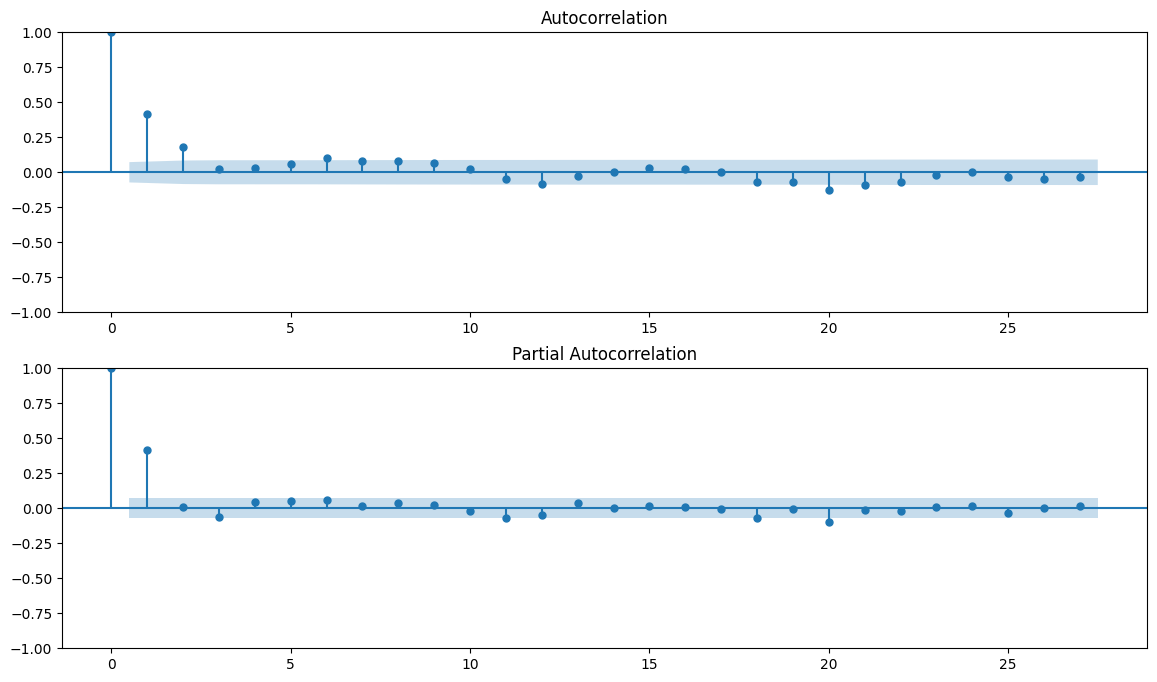

In [20]:
# Graphing the ACF plot
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
plot_acf(df_stationary.Revenue, lags=27, ax=ax1)

# Graphing the pacf plot
ax2 = fig.add_subplot(212)
plot_pacf(df_stationary.Revenue, lags=27, ax=ax2)
plt.show()

#### Spectral Density

The spectral density visualization indicates that revenue variance is concentrated at lower frequencies. This suggests that the time series has long-term variations rather than rapid, short-term variations.

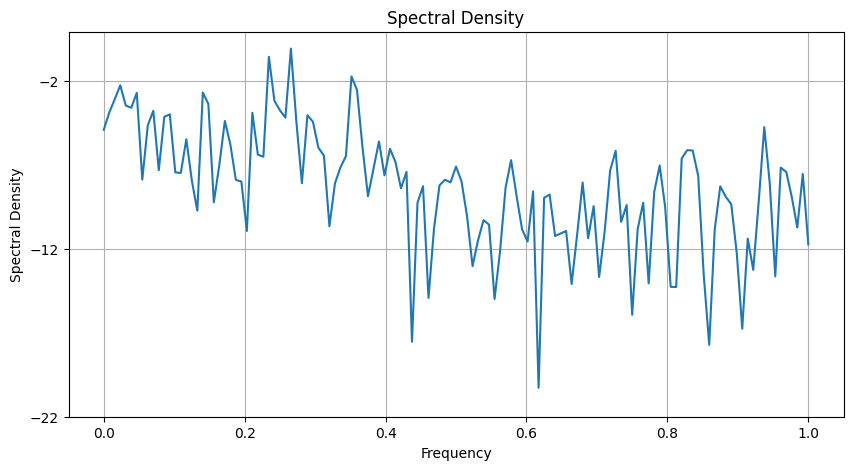

In [21]:
# Plot spectral density
plt.figure(figsize=(10, 5))
plt.psd(x=df_stationary['Revenue'])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

## D2: ARIMA Model

The ACF and PACF plots on the stationary data in section D1 suggest an ARIMA model of (1,0,1) would be a good model to begin with. However, since the training data set is non-stationary data, it would be more appropriate to set d = 1, which suggests an ARIMA model of (1,1,1). ARIMA(1,1,1) results in an AIC of 674.516. 

To assist in determining the appropriate ARIMA model, this analysis uses Auto ARIMA to test different models. Auto ARIMA actually reveals an ARIMA(0,1,2) as being the best model for this data set based on the AIC score. The ARIMA(0,1,2) model has an AIC of 669.462 - slightly better than ARIMA(1,1,1). Given these results, ARIMA(0,1,2 will be utilized for this analysis.

#### Manual ARIMA model

In [22]:
# Manual ARIMA model
model1 = ARIMA(train['Revenue'], order=(1,1,1))
model1 = model1.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  551
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -334.260
Date:                Fri, 17 Jan 2025   AIC                            674.519
Time:                        14:23:02   BIC                            687.449
Sample:                    01-01-2023   HQIC                           679.572
                         - 07-04-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4534      0.101      4.483      0.000       0.255       0.652
ma.L1         -0.0512      0.111     -0.460      0.646      -0.269       0.167
sigma2         0.1974      0.013     15.244      0.000       0.172       0.223
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.94   Prob(JB):                         0.41
Heteroskedasticity (H):               1.05   Skew:                            -0.03
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Auto ARIMA

In [23]:
# Perform Auto Arima
auto_model = auto_arima(train['Revenue'], trace=True)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=673.149, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=772.964, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=674.252, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=695.569, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=772.440, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=672.218, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=670.772, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=672.090, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=675.919, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=673.986, Time=1.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=669.462, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=694.534, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=670.862, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=670.730, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=674.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  551
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -331.731
Date:                Fri, 17 Jan 2025   AIC                            669.462
Time:                        14:23:08   BIC                            682.392
Sample:                    01-01-2023   HQIC                           674.515
                         - 07-04-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3929      0.041      9.557      0.000       0.312       0.473
ma.L2          0.2217      0.042      5.340      0.000       0.140       0.303
sigma2         0.1955      0.013     15.349      0.000       0.171       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.86   Prob(JB):                         0.39
Heteroskedasticity (H):               1.05   Skew:                            -0.05
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Final ARIMA model

In [24]:
# Manual ARIMA model
modelm = ARIMA(train['Revenue'], order=(0,1,2))
modelm = modelm.fit()
modelm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  551
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -331.731
Date:                Fri, 17 Jan 2025   AIC                            669.462
Time:                        14:23:08   BIC                            682.392
Sample:                    01-01-2023   HQIC                           674.515
                         - 07-04-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3929      0.041      9.557      0.000       0.312       0.473
ma.L2          0.2217      0.042      5.340      0.000       0.140       0.303
sigma2         0.1955      0.013     15.349      0.000       0.171       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.86   Prob(JB):                         0.39
Heteroskedasticity (H):               1.05   Skew:                            -0.05
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## D3: Forecasting Using ARIMA Model

The plot below show the forecasted revenues for the 180 days in the test data set. The output is particularly interesting as it the ARIMA model forecasts about 14.025 million in revenue for the first day in the test set, increases by 0.04 million to 14.065, and remains flat for the remaining 179 days.

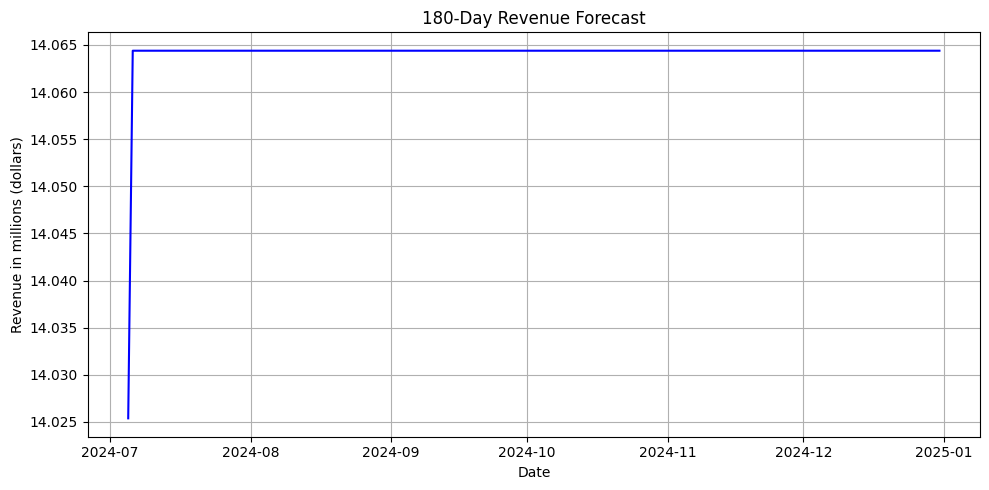

In [25]:
# Forecast using the ARIMA model selected in D2
predictions = modelm.get_prediction(start=test.index[0], end=test.index[-1])

# Plot the predictions
plt.figure(figsize=(10,5))
plt.plot(predictions.predicted_mean.index, predictions.predicted_mean.values, color='blue', label='Forecast')
plt.title('180-Day Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue in millions (dollars)')
plt.grid(True)
plt.tight_layout()
plt.show()

## D4: Output and Calculations

The following plots compares the forecasted values against the original data set. It also includes the confidence intervals of the forecasted values.

As discussed in section D3, the results of the forecast are particularly flat. In fact, the small difference observed between the first few days of the forecast is so small relative to the data set that it does not appear visually when comparing the forecast versus the actual data. The revenue forecast actually fell short on most days. It is also interesting to note that the bounds of the confidence interval are quite distant. 

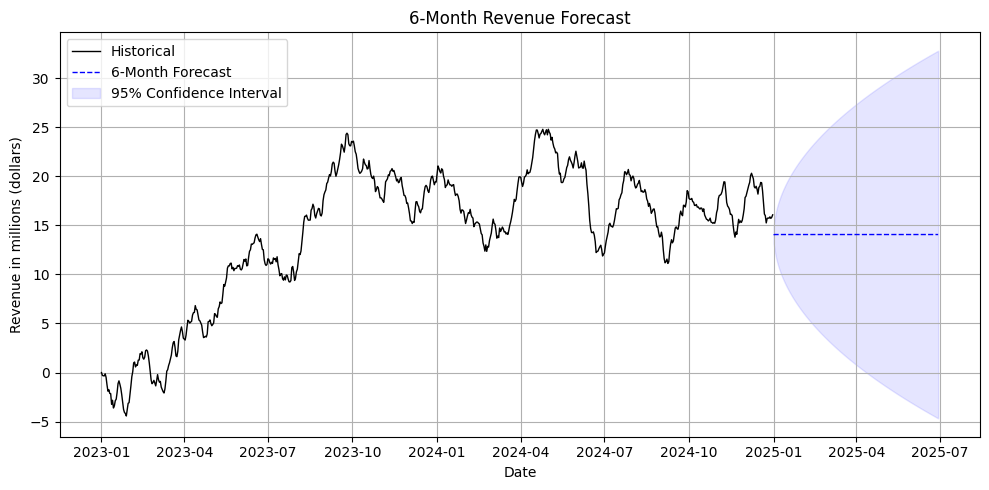

In [36]:
# Calculate 6-month forecast (180 days)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=180, freq='D')
future_predictions = modelm.get_forecast(steps=180)

# Create the plot
plt.figure(figsize=(10, 5))

# Plot historical values
plt.plot(df.index,
        df['Revenue'],
        color='black',
        label='Historical',
        linewidth=1)

# Plot forecast values
plt.plot(future_dates,
        future_predictions.predicted_mean,
        color='blue',
        label='6-Month Forecast',
        linestyle='--',
        linewidth=1)

# Add confidence intervals
conf_int = future_predictions.conf_int()
plt.fill_between(future_dates,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='blue',
                alpha=0.1,
                label='95% Confidence Interval')

plt.title('6-Month Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue in millions (dollars)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Forecast vs Actual w/ Confidence Cone

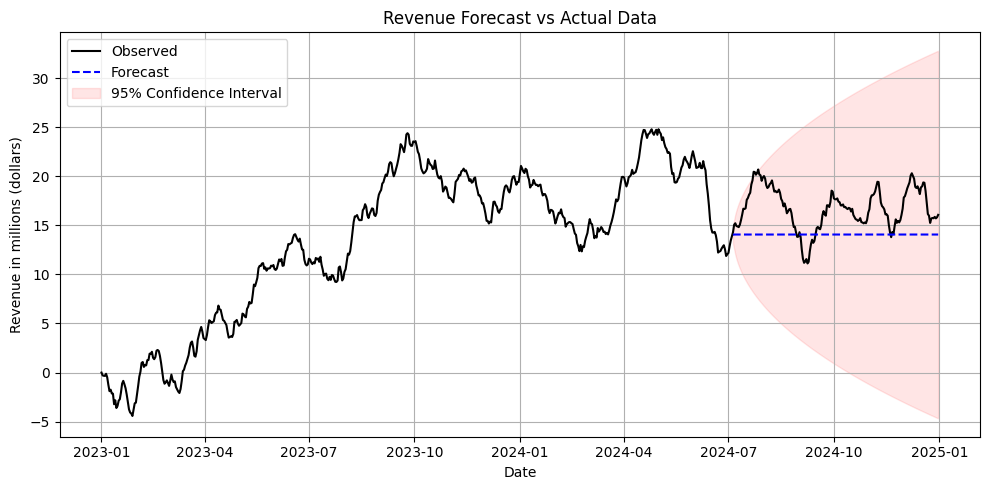

In [28]:
# Create the plot
plt.figure(figsize=(10, 5))

# Plot original observed values
plt.plot(df.index, 
         df.values, 
         color='black', 
         label='Observed')

# Plot predicted mean
plt.plot(predictions.predicted_mean.index,
         predictions.predicted_mean.values,
         color='blue',
         label='Forecast',
         linestyle='--')

# Plot confidence intervals
conf_int = predictions.conf_int()
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='red',
                 alpha=0.1,
                 label='95% Confidence Interval')

plt.title('Revenue Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Revenue in millions (dollars)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model Evaluation Metrics

RMSE = 3.39 million dollars
- On average, the model's predictions deviate from actual revenue by 3.39 million dollars. Given the average daily revenue is 14.18 million dollars, this represents an average error of 23.9% of daily revenue.

R² = -1.5918
- The model is performing worse than just predicting the mean revenue for every day.

In [29]:
# Create a comparison DataFrame
predicted_mean = predictions.predicted_mean
forecast_comparison = pd.DataFrame({
    'Actual': test['Revenue'],
    'Predicted': predicted_mean
})

# Calculate MSE
mse = mean_squared_error(forecast_comparison['Actual'], forecast_comparison['Predicted'])

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(forecast_comparison['Actual'], forecast_comparison['Predicted'])

# Print the metrics
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared Score (R²): {r2:.4f}")

Root Mean Squared Error (RMSE): 3.39
R-squared Score (R²): -1.5918


#### Analyze Error at a Daily Level

The daily breakdown drills in to the forecasted period specifically. By analyzing the first 10 forecasted days and the last 10 forecasted days, it is apparrent that the error is small at the beginning of the forecasting period, but escalates quickly to being double digit errors. The line graph visualizes the actual error (difference between the actual value and the predicted value). It allows us to see that at the model's worst, it under forecasts several days by more than 6 million dollars and over forecasts by over 2 million dollars on a handful of days.


Detailed Daily Comparison (First 20 Days):
            Actual  Predicted  Error  Absolute Error  Percentage Error
2024-07-05  14.302     14.025  0.277           0.277             1.936
2024-07-06  15.066     14.064  1.001           1.001             6.646
2024-07-07  15.212     14.064  1.147           1.147             7.543
2024-07-08  14.930     14.064  0.866           0.866             5.798
2024-07-09  14.885     14.064  0.821           0.821             5.516
2024-07-10  14.818     14.064  0.753           0.753             5.085
2024-07-11  15.070     14.064  1.006           1.006             6.675
2024-07-12  15.544     14.064  1.479           1.479             9.517
2024-07-13  16.089     14.064  2.024           2.024            12.581
2024-07-14  16.696     14.064  2.631           2.631            15.760
2024-07-15  16.664     14.064  2.600           2.600            15.600
2024-07-16  16.736     14.064  2.672           2.672            15.964
2024-07-17  17.604     14.064  3.

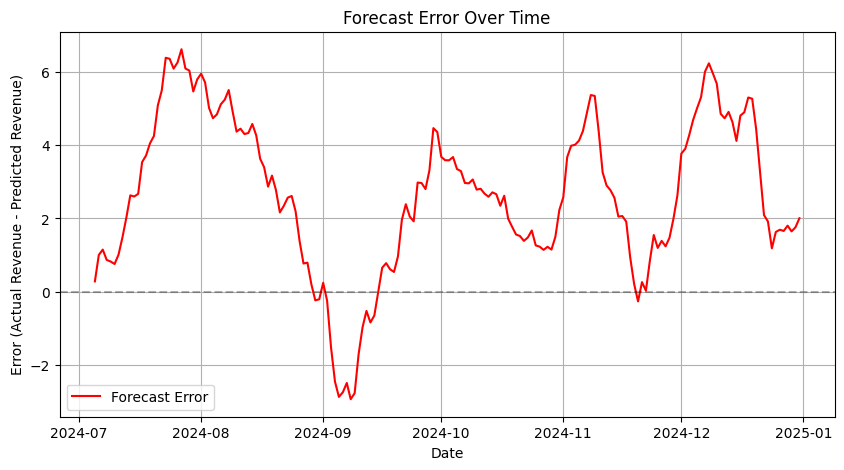

In [30]:
# Calculate error metrics
forecast_comparison['Error'] = forecast_comparison['Actual'] - forecast_comparison['Predicted']
forecast_comparison['Absolute Error'] = abs(forecast_comparison['Error'])
forecast_comparison['Percentage Error'] = (abs(forecast_comparison['Error']) / abs(forecast_comparison['Actual'])) * 100

# Display first and last 10 days
print("\nDetailed Daily Comparison (First 20 Days):")
print(forecast_comparison.head(20).round(3))
print("\nDetailed Daily Comparison (Last 20 Days):")
print(forecast_comparison.tail(20).round(3))

# Error over time plot
plt.figure(figsize=(10, 5))
plt.plot(test.index, forecast_comparison['Error'], color='red', label='Forecast Error')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title('Forecast Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error (Actual Revenue - Predicted Revenue)')
plt.grid(True)
plt.legend()

## D5: Code

The code used to support the implementation of the time series model is provided in previous sections of this analysis.

# Part V: Data Summary and Implications

## E1: Results

**ARIMA Model Selection**

The final ARIMA(0,1,2) model was selected through analysis of autocorrelation (ACF) and partial autocorrelation (PACF) functions as well as using Auto ARIMA. Initially, analysis of the ACF and PACF plots suggested an ARIMA(1,1,1) model might be appropriate due to the significant spikes at early lags. However, Auto ARIMA testing revealed that ARIMA(0,1,2) produced a better AIC score of 669.462 compared to ARIMA(1,1,1)'s score of 674.519. The model parameters show statistically significant MA terms with p-values < 0.001, which confirms that the ARIMA(0,1,2) is appropriate.


**Prediction Interval of the Forecast** 

The prediction interval of the forecast encompasses the final 180 days of the original data set. The initial predictions show tighter confidence bounds with errors around 1.9-6.6% in the first week of the forecast period. However, the percent error quickly reached double digits. By day 9 of the forecast period, the error is greater than 12%. It only takes 17 days of the forecast period for the error percentage to exceed 25%. Analyzing the confidence intervals across the entire 180-day span shows that the error rate does improve at times, but ultimately uncertainty in the predictions increase as time goes on. It is important to note that these intervals are statistically significant at the 95% confidence level. The issue becomes that the bounds of the intervals are large in order to be 95% confident with this model. For example, by day 20, the confidence interval included almost a 6 million dollar swing in either direction from the predicted value. Given that the average daily revenue for the data set is roughly 14.18 million dollars, 6 million dollars in either direction is very significant.


**Justification of Forecast Length**

This analysis chose to attempt a longer term forecast of 180 days. From a business perspective, while it is helpful to forecast  short term, leaders are more likely to want a forecast that extends out to a year in length, if not more. Considering the data set size, a length of 180 days represents approximately 25% of the total available data (731 days), which maintains a reasonable training-to-test ratio. Finally, 180 days was also selected for this analysis to test how far ARIMA could accurately predict. Dr. Festus Elleh mentions in a webinar that ARIMA does not perform well with predictions over 6 months in length, so 180 days was selected for this analysis in order to test that theory. 


**Model Evaluation and Error Metrics**

The model's performance metrics indicate significant challenges in forecast accuracy:
- RMSE: 3.39 million dollars, representing an average deviation of 23.9% from actual daily revenue
- R² score: -1.5918, indicating the model performs worse than simply predicting the mean revenue
- Residual analysis shows no significant autocorrelation in the errors, suggesting the model captures the time series structure
- Daily error analysis reveals the forecast accuracy worsens over time
These results suggest that while the model captures some revenue patterns, it is not likely useful for revenue forecasting.


**Summary**

To circle back to the question proposed in Section A1, "Is it possible to accurately predict 180 days of the hospital system's revenue forecast using an ARIMA forecasting model?", it does not seem like it is using this data set. The R-squared metric used for model evaluation determined that this model is actually worse than just using the mean daily revenue to make a forecast. However, this does not seem entirely like a problem with the model itself, but more so that the underlying data is not suitable for ARIMA. There is an obvious upward trend at the beginning of the data set, which makes sense because it is when operations began. Revenue leveled out as operational stability was gained. The model would likely require a data set that is trained solely on data not influenced by the hospital beginning operations. A hospital system can only become operational once, so trying to capture that behavior in the model does not make sense. There also may be slight seasonality, but the data set is not large enough to confirm that considering the beginning of operations trend or to minimize its impact. To conclude, while we technically can predict 180 days of the hospital system's revenue forecast using ARIMA, to do so accurately would require beginning with a data set that represents less nuanced revenue patterns.

## E2: Annotated Visualization

The following visualization includes the original data compared against the forecasted data along with the confidence interval of the forecast. (Repeated from Section D4.)

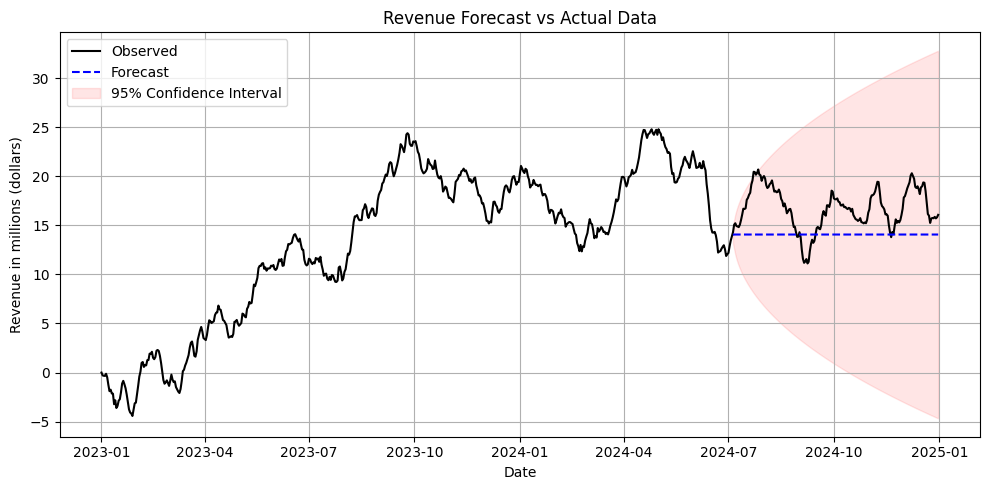

In [31]:
# Create the plot
plt.figure(figsize=(10, 5))

# Plot original observed values
plt.plot(df.index, 
         df.values, 
         color='black', 
         label='Observed')

# Plot predicted mean
plt.plot(predictions.predicted_mean.index,
         predictions.predicted_mean.values,
         color='blue',
         label='Forecast',
         linestyle='--')

# Plot confidence intervals
conf_int = predictions.conf_int()
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='red',
                 alpha=0.1,
                 label='95% Confidence Interval')

plt.title('Revenue Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Revenue in millions (dollars)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The revenue graph shows historical data from January 2023 through December 2024 (solid black line). It also shows a forecast for the last 180 days of 2024 (dashed blue line with pink confidence interval). Revenue started off in the negative when operations began in 2023, but showed strong growth through October 2023. While actual revenue has been volatile throughout the period, the forecast suggests the revenue will stable out going forward. However, the widening pink confidence interval indicates increasing uncertainty in these predictions.

## E3: Recommendation

There is no practical significance for this model given its poor predictive capability. Therefore, no actions should be taken based on the data analyzed within this analysis. The best course of action would be to repeat this analysis with a less nuanced dataset.

The first 10 months of the dataset represent the initial growth the hospital system experienced when business operations began. However, since business operations can commence only once for a hospital system, the dataset would be better off by excluding this period when building a time series forecasting model. It would be more appropriate to use data starting in year 2 as a baseline. Additionally, alongside excluding the nuanced first-year data, the dataset would need to become more robust to allow for the identification and accounting of seasonality and other recurring trends. Furthermore, practical business application of this model would likely benefit from conducting the analysis on a hospital-by-hospital basis. A more granular analysis that is then aggregated to the hospital system level would help account for variables such as new hospital openings or the addition of new clinics at existing hospitals, for example.

# Part VI: Reporting

## G: Sources for Third-Party Code

Elleh, F. (2025, January). ARIMA Time Series Forecasting. Lectures. 

GeeksforGeeks. (2022, July 5). Plot the power spectral density using Matplotlib - Python. GeeksforGeeks. https://www.geeksforgeeks.org/plot-the-power-spectral-density-using-matplotlib-python/ 

GeeksforGeeks. (2023a, November 30). Seasonality detection in time series data. https://www.geeksforgeeks.org/seasonality-detection-in-time-series-data/ 

Saadeddin, Z. (2025, January 7). Arima for Time Series Forecasting: A complete guide. DataCamp. https://www.datacamp.com/tutorial/arima 

Sewell, W. (2025, January). ARIMA Time Series Forecasting. Lectures. 

## H: Sources

Chatterjee, S. (2018, January 30). Time series analysis using Arima model in R. DataScience+. https://datascienceplus.com/time-series-analysis-using-arima-model-in-r/ 

Fulton, J. (n.d.). Intro to ACF and PACF: Python. https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?ex=1&learningMode=course 

Medium. (2023, July 17). Understanding arima models: A comprehensive guide to time series forecasting. Medium. https://medium.com/@data-overload/understanding-arima-models-a-comprehensive-guide-to-time-series-forecasting-dfc7207f2406

Sangarshanan. (2018, October 3). Time series forecasting - arima models. Medium. https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
